In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import critical_loads as cl
import statsmodels.formula.api as sm

plt.style.use('ggplot')

In [2]:
# Connect to Docker PostGIS
eng = nivapy.da.connect(src='postgres',
                        db_name='critical_loads',
                        port = 25432)

Connection successful.


# Critical loads for vegetation (high-resolution method; 2018 onwards)

In Spring 2018, the worflow for calculating critical loads for vegetation [was refined](http://nbviewer.jupyter.org/github/JamesSample/critical_loads/blob/master/notebooks/critical_loads_workflow_new_grid.ipynb#1.-Vegetation) to make use of new, higher-resolution input datasets. During November 2018, data handling for the Critical Loads project was also redesigned, with the ultimate aim of centralising and migrating all key datasets onto NIVA's new cloud platform. This notebook estimates exceedences of critical loads for vegetation using both the revised (Spring 2018) workflow and the new (November 2018) data structures. Calculations here assume that deposition data are supplied using NILU's 0.1 degree grid, and the vegetation map is based on 30 m resolution **raster** satellite imagery.

**Note:** Data supplied prior to 2017-18 use a different deposition grid (the "BLR" grid) and vector vegetation data. **The workflow described here only applies to data supplied from 2017-18 onwards**; earlier data is *not* compatible with the calculations described here.    

**To do:** Create a notebook to repeat the old workflow as well.

## 1. Upload new deposition data (optional)

The first step, if desired, is to upload new deposition data from NILU for the time period of interest.

### 1.1. Define a new deposition series

The code below extracts the existing deposition series already defined in the database. Click `'Add row'` to create a new row at the bottom of the table (initially a duplicate of the last row), then double-click to edit values and define the new data series. Note that all columns are mandatory.

In [ ]:
# Define a new deposition series
ser_grid = cl.view_dep_series(eng)
ser_grid

In [ ]:
# Add new series to database
add_df = cl.add_dep_series(ser_grid, eng)
add_df

### 1.2. Upload deposition data

In 2017, NILU supplied raw data for the 0.1 degree grid in `.dat` format. The code here assumes new data are supplied in the same way.

Modify the user options in the cell below to match your new data:

 * `ser_id` is the ID of the new row that was added to the table above
 
 * `dat_fold` is the *relative* path to a folder containing **only** the `.dat` files you wish to upload

In [3]:
# series_id to upload
ser_id = 28

# Folder containing .dat files
dat_fold = r'../../../data/raw/nilu_dep/2012-2016'

assert ser_id > 27, ('ERROR: The workflow in this notebook is only compatible with recent datasets '
                     'using the 0.1 degree NILU deposition grid. For older datasets, see notebook 2.')

In [ ]:
# Process NILU data and add to db
df = cl.upload_nilu_0_1deg_dep_data(dat_fold, eng, ser_id)
df.head()

### 1.3. Map N deposition data

The code below generates a choropleth map of the N deposition data (used for the vegetation calculations).

In [4]:
# Get dep data from database
dep_gdf = cl.n_deposition_as_gdf_0_1deg(ser_id, eng)
dep_gdf.head()

,geom,cell_id,n_dep
0,(POLYGON ((5655.001419191016 6470694.353263143...,58050655,840.0
1,(POLYGON ((9788.008778641524 6465964.999440175...,58050665,911.0
2,"(POLYGON ((17388.7264354463 6469241.096078512,...",58050675,1014.0
3,(POLYGON ((22572.27425884473 6462862.544306678...,58050685,1070.0
4,"(POLYGON ((27984.3201594979 6458257.534750269,...",58050695,1108.0


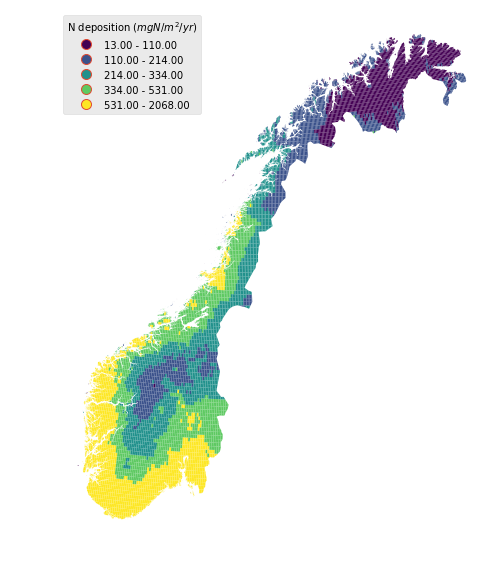

In [6]:
# Choropleth map
dep_gdf.plot(column='n_dep', 
             scheme='quantiles',
             edgecolor=None,
             legend=True,
             legend_kwds={'loc':'upper left',
                          'title': 'N deposition ($mgN/m^2/yr$)'},
             figsize=(8,8))

plt.axis('off')
plt.tight_layout()

## 2. Calculate critical loads for vegetation

Critical loads for vegatation are calculated as follows:

 1. Extract raster data representing critical loads for vegetation in GeoTiff format and save locally (this is done for performance reasons)
 
 2. Within the database, link deposition data for the time period of interest to the 0.1 degree vector grid provided by NILU
 
 3. Convert the vector grid to a raster with the same properties (extent, cell size etc.) as the critical loads grid
 
 4. Calculate the exceedance for each pixel, $i$, as $E_i = D_i - C_i$ (where $E$ is exceedance, $D$ is deposition and $C$ is the critical load)
 
 5. Save the exceedance grid as a GeoTiff. Calculate the total exceeded area for Norway as a whole, and the proportion exceeded in each 0.1 degree vector cell
 
 6. Write the results (i.e. the exceedance raster and the table & vector summaries) back to the database
 
### 2.1. Extract raster of critical loads

**Note:** The analysis undertaken during spring 2018 made use of a 30 m resolution vegetation grid. The same grid could be used here if desired, but the calculations are slow and also at the limit of what my laptop can fit in memory while running Docker. For the work here, I have therefore decided to use the 60 m resolution vegetation grid, because this gives essentailly the same output and is much faster for testing & development. On Google Cloud memory should not be an issue, so it will be possible for the user to choose between 30 m and 60 m resolution datasets simply by modifiying the code in the cells below.

Note also that, at present, the relevant rasters are available on the network here 

    K:\Prosjekter\JES\Critical_Loads\GIS\Raster
    
It is probably quicker to copy the rasters from this network folder to a location on your system, rather than extracting (and decompressing) them from PostGIS.

In [ ]:
## Extract raster of CLs to .tif
## .tif to create
#cl_tif = r'../../../data/raster/sat_veg_60m_cr_lds_div100.tif'
#
## Get data from db
#nivapy.da.postgis_raster_to_geotiff('critical_loads',
#                                    'host.docker.internal',
#                                    25432,
#                                    'vegetation',
#                                    'sat_veg_60m_cr_lds_div100',
#                                    cl_tif)

### 2.2. Calculate exceedance

The code below first converts the deposition data (from Section 1.3, above) into a GeoTiff matching the critical loads grid. The critical loads and deposition grids are then combined to estimate exceedances, and summary results at national scale (total area exceeded etc.) are saved back to the database.

**Note:** Deposition values for each grid cell will be rounded to the nearest integer (mgN/m2/year) and the grid saved in 16-bit integer format. This keeps file sizes manageable but, nevertheless, this step is computationally intensive and quite slow.

In [7]:
# CL raster (created in Section 2.1)
cl_tif = r'../../../data/raster/sat_veg_60m_cr_lds_div100.tif'

# Output deposition .tif to create
dep_tif = r'../../../data/raster/ndep_12-16_60m.tif'

# Output exceedance .tif to create
ex_tif = r'../../../data/raster/veg_ex_12-16_60m.tif'

In [8]:
# Create a deposition raster
cl.create_n_deposition_raster_0_1deg(ser_id, dep_tif, cl_tif, eng, ndv=-1)

# Calculate exceedance
ex_df = cl.calc_vegetation_exceedance_0_1deg(dep_tif, cl_tif, ex_tif, ser_id)

ex_df

/home/jovyan/work/python/critical_loads_2/notebooks/critical_loads.py:393: RuntimeWarning: invalid value encountered in greater
  ex_area = np.count_nonzero(ex_grid > 0)*cs*cs/1.E6
/home/jovyan/work/python/critical_loads_2/notebooks/critical_loads.py:396: RuntimeWarning: invalid value encountered in less
  ex_grid[ex_grid<0] = 0


,series_id,medium,total_area_km2,exceeded_area_km2,exceeded_area_pct
0,28,vegetation,322185,61806,19


In [9]:
# Write summary data to db
ex_df.to_sql('national_summary', 
             eng,
             'summaries',
             if_exists='append',
             index=False)

### 2.3 Zonal statistics

The code below calculates exceedance summary statistics for each 0.1 degree grid cell. Results are saved back to the database.

In [10]:
# Calculate zonal statistics
gdf = cl.exceedance_stats_per_0_1deg_cell(ex_tif, ser_id, eng)

/home/jovyan/work/python/critical_loads_2/notebooks/critical_loads.py:623: UserWarning: Warning: converting a masked element to nan.
  'min': float(masked.min()),
/home/jovyan/work/python/critical_loads_2/notebooks/critical_loads.py:624: UserWarning: Warning: converting a masked element to nan.
  'mean': float(masked.mean()),
/home/jovyan/work/python/critical_loads_2/notebooks/critical_loads.py:625: UserWarning: Warning: converting a masked element to nan.
  'max': float(masked.max()),
/home/jovyan/work/python/critical_loads_2/notebooks/critical_loads.py:626: UserWarning: Warning: converting a masked element to nan.
  'std': float(masked.std()),
/home/jovyan/work/python/critical_loads_2/notebooks/critical_loads.py:627: UserWarning: Warning: converting a masked element to nan.
  'sum': float(masked.sum()),
/home/jovyan/work/python/critical_loads_2/notebooks/critical_loads.py:623: UserWarning: Warning: converting a masked element to nan.
  'min': float(masked.min()),
/home/jovyan/work/py

### 2.4. View results

In [11]:
# Extract exceedance summaries
ex_gdf = cl.veg_exceedance_as_gdf_0_1deg(ser_id, eng)

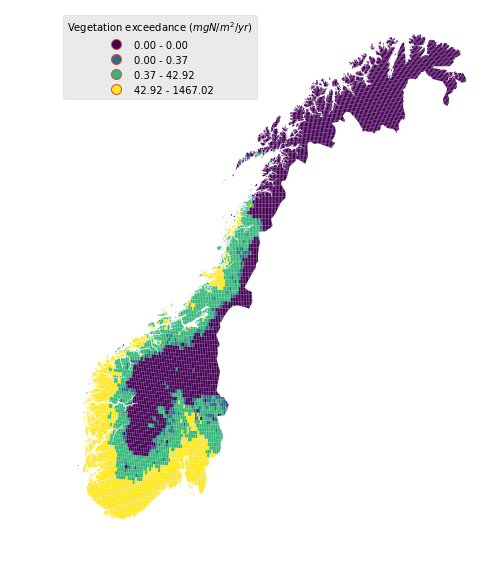

In [12]:
# Choropleth map
ex_gdf.plot(column='mean', 
            scheme='quantiles',
            edgecolor=None,
            legend=True,
            legend_kwds={'loc':'upper left',
                         'title': 'Vegetation exceedance ($mgN/m^2/yr$)'},
            figsize=(8,8))

plt.axis('off')
plt.tight_layout()